In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gradio as gr

import nltk
from nltk.corpus import stopwords
 
#nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/Users/pratishmurugan/miniforge3/envs/langchainllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read data
food_rec = pd.read_csv('Food_rec_data.csv')
indian_food_rec = pd.read_csv('indian_food - 4.csv')

In [3]:
food_rec.head()

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,4,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


In [4]:
indian_food_rec['course'] = 'Indian ' + indian_food_rec['course']
indian_food_rec.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,Indian dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,Indian dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,Indian dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,Indian dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,Indian dessert,West Bengal,East


In [5]:
#Data Cleaning

## Merge the two dataframes 
### Lets only keep the columns that we need, that is "name, describle/ingredients, diet/veg_non, c_type/course"

indian_food_rec.drop(columns=['prep_time', 'cook_time', 'flavor_profile', 'state', 'region'], axis = 1, inplace=True)
food_rec.drop('Food_ID', axis=1, inplace=True)

In [6]:
#rename columns of food_rec to match the indian_food_rec
food_rec.rename(columns={'Name':'name', 'Describe':'ingredients', 'Veg_Non':'diet', 'C_Type':'course'}, inplace=True)
food_rec.head()

,name,course,diet,ingredients
0,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


In [7]:
#reorder to merge
indian_food_rec = indian_food_rec.loc[:, ['name', 'course', 'diet', 'ingredients']]
indian_food_rec.head()

,name,course,diet,ingredients
0,Balu shahi,Indian dessert,vegetarian,"Maida flour, yogurt, oil, sugar"
1,Boondi,Indian dessert,vegetarian,"Gram flour, ghee, sugar"
2,Gajar ka halwa,Indian dessert,vegetarian,"Carrots, milk, sugar, ghee, cashews, raisins"
3,Ghevar,Indian dessert,vegetarian,"Flour, ghee, kewra, milk, clarified butter, su..."
4,Gulab jamun,Indian dessert,vegetarian,"Milk powder, plain flour, baking powder, ghee,..."


In [8]:
#Create a new dataframe speciallly for arabic dishes 

arabic_dishes = pd.DataFrame({
    "name": ["Falafel", "Kunafah", "Mandi"],
    "course": ["Snack", "Dessert", "Main Course"],
    "diet": ["Veg", "Veg", "Non-Veg"],
    "ingredients": [
        "Chickpeas, parsley, coriander, garlic, onion, cumin, coriander seeds, salt, black pepper, baking soda, sesame seeds, olive oil for frying",
        "Kataifi dough, mozzarella cheese, unsalted butter, sugar, water, lemon juice, orange blossom water, ground pistachios for garnish",
        "Rice, chicken or lamb, saffron, cardamom pods, cloves, cinnamon sticks, bay leaves, onions, garlic, dried lime (loomi), cumin powder, coriander powder, salt, black pepper, ghee (clarified butter)"
    ]
})
arabic_dishes.head()

,name,course,diet,ingredients
0,Falafel,Snack,Veg,"Chickpeas, parsley, coriander, garlic, onion, ..."
1,Kunafah,Dessert,Veg,"Kataifi dough, mozzarella cheese, unsalted but..."
2,Mandi,Main Course,Non-Veg,"Rice, chicken or lamb, saffron, cardamom pods,..."


In [9]:
## add more dishes to the arabic dishes dataframe
arabic_dishes = pd.concat([arabic_dishes, pd.DataFrame({
    "name": ["Shawarma", "Hummus", "Tabbouleh", "Baba Ganoush", "Fattoush"],
    "course": ["Main Course", "Snack", "Salad", "Snack", "Salad"],
    "diet": ["Non-Veg", "Veg", "Veg", "Veg", "Veg"],
    "ingredients": [
        "Chicken or lamb, yogurt, garlic, lemon juice, cumin, paprika, turmeric, cardamom, cinnamon, black pepper, vinegar, salt, olive oil",
        "Cooked chickpeas, tahini (sesame paste), lemon juice, garlic, olive oil, salt, paprika, cumin",
        "Bulgur wheat, parsley, mint, tomato, cucumber, green onions, lemon juice, olive oil, salt, pepper",
        "Roasted eggplant, tahini, lemon juice, garlic, olive oil, salt, parsley, smoked paprika",
        "Lettuce, tomatoes, cucumber, radishes, mint, parsley, green onions, sumac, olive oil, lemon juice, salt, pepper, toasted pita bread"
    ]
})])
arabic_dishes.head(10)

,name,course,diet,ingredients
0,Falafel,Snack,Veg,"Chickpeas, parsley, coriander, garlic, onion, ..."
1,Kunafah,Dessert,Veg,"Kataifi dough, mozzarella cheese, unsalted but..."
2,Mandi,Main Course,Non-Veg,"Rice, chicken or lamb, saffron, cardamom pods,..."
0,Shawarma,Main Course,Non-Veg,"Chicken or lamb, yogurt, garlic, lemon juice, ..."
1,Hummus,Snack,Veg,"Cooked chickpeas, tahini (sesame paste), lemon..."
2,Tabbouleh,Salad,Veg,"Bulgur wheat, parsley, mint, tomato, cucumber,..."
3,Baba Ganoush,Snack,Veg,"Roasted eggplant, tahini, lemon juice, garlic,..."
4,Fattoush,Salad,Veg,"Lettuce, tomatoes, cucumber, radishes, mint, p..."


In [10]:
arabic_dishes = pd.concat([arabic_dishes, pd.DataFrame({
    "name": ["Maqluba", "Kibbeh", "Mujaddara", "Manakeesh", "Sayadiyah", 
             "Harira", "Sambusak", "Zaatar Salad", "Shish Barak", "Umm Ali"],
    "course": ["Main Course", "Snack", "Main Course", "Snack", "Main Course", 
               "Soup", "Snack", "Salad", "Main Course", "Dessert"],
    "diet": ["Non-Veg", "Non-Veg", "Veg", "Veg", "Non-Veg", 
             "Non-Veg", "Veg", "Veg", "Non-Veg", "Veg"],
    "ingredients": [
        "Rice, chicken or lamb, potatoes, cauliflower, eggplant, tomatoes, spices",
        "Bulgur, minced onions, finely ground lean beef or lamb, Middle Eastern spices",
        "Lentils, rice, onions, cumin, olive oil",
        "Dough, za'atar, olive oil, cheese or ground meat",
        "Fish, rice, onions, spices, pine nuts",
        "Tomatoes, lentils, chickpeas, lamb, cilantro, celery, onion, spices",
        "Dough, cheese, spinach, onions, pine nuts, spices",
        "Lettuce, tomatoes, cucumber, radish, zaatar, lemon juice, olive oil",
        "Dough dumplings, minced meat, yogurt, pine nuts, coriander",
        "Puff pastry, milk, sugar, nuts, coconut flakes, raisins"
    ]
})])

arabic_dishes = pd.concat([arabic_dishes, pd.DataFrame({
    "name": ["Basbousa", "Halva", "Knafeh", "Baklava", "Qatayef", 
             "Mhalbi", "Barazek", "Falooda", "Luqaimat", "Roz Bel Laban"],
    "course": ["Dessert", "Dessert", "Dessert", "Dessert", "Dessert", 
               "Dessert", "Dessert", "Dessert", "Dessert", "Dessert"],
    "diet": ["Veg", "Veg", "Veg", "Veg", "Veg", 
             "Veg", "Veg", "Veg", "Veg", "Veg"],
    "ingredients": [
        "Semolina, coconut, yogurt, sugar, almonds",
        "Sesame paste, sugar, pistachios, cardamom",
        "Kataifi dough, sweet cheese, syrup, pistachios",
        "Phyllo pastry, nuts, honey, syrup",
        "Pancake dough, sweet cheese or nuts, sugar syrup",
        "Rice, milk, sugar, cinnamon, pistachios",
        "Sesame seeds, pistachios, honey, butter, sugar",
        "Milk, rose syrup, vermicelli, pistachios, basil seeds",
        "Flour, yeast, sugar, saffron, cardamom",
        "Rice pudding, milk, sugar, vanilla, cinnamon"
    ]
})])
    
    
#Add the name arabic to the course column
arabic_dishes['course'] = 'Arabic ' + arabic_dishes['course']


arabic_dishes.reset_index(drop=True)

,name,course,diet,ingredients
0,Falafel,Arabic Snack,Veg,"Chickpeas, parsley, coriander, garlic, onion, ..."
1,Kunafah,Arabic Dessert,Veg,"Kataifi dough, mozzarella cheese, unsalted but..."
2,Mandi,Arabic Main Course,Non-Veg,"Rice, chicken or lamb, saffron, cardamom pods,..."
3,Shawarma,Arabic Main Course,Non-Veg,"Chicken or lamb, yogurt, garlic, lemon juice, ..."
4,Hummus,Arabic Snack,Veg,"Cooked chickpeas, tahini (sesame paste), lemon..."
5,Tabbouleh,Arabic Salad,Veg,"Bulgur wheat, parsley, mint, tomato, cucumber,..."
6,Baba Ganoush,Arabic Snack,Veg,"Roasted eggplant, tahini, lemon juice, garlic,..."
7,Fattoush,Arabic Salad,Veg,"Lettuce, tomatoes, cucumber, radishes, mint, p..."
8,Maqluba,Arabic Main Course,Non-Veg,"Rice, chicken or lamb, potatoes, cauliflower, ..."
9,Kibbeh,Arabic Snack,Non-Veg,"Bulgur, minced onions, finely ground lean beef..."


In [11]:
#heathy dishes dataset
healthy_dishes = pd.DataFrame({
    "name": [
        "Quinoa Salad", "Grilled Salmon", "Veggie Stir Fry", "Avocado Toast", "Chia Pudding",
        "Kale Smoothie", "Grilled Chicken Salad", "Broccoli Soup", "Sweet Potato Hash", "Oatmeal Pancakes",
        "Mediterranean Bowl", "Spinach Omelette", "Turkey Wrap", "Lentil Soup", "Roasted Vegetables",
        "Cauliflower Rice", "Greek Yogurt Parfait", "Vegetable Quiche", "Stuffed Peppers", "Black Bean Burger"
    ],
    "course": [
        "Salad", "Main Course", "Main Course", "Snack", "Dessert",
        "Drink", "Salad", "Soup", "Main Course", "Breakfast",
        "Main Course", "Breakfast", "Snack", "Soup", "Side Dish",
        "Side Dish", "Dessert", "Main Course", "Main Course", "Main Course"
    ],
    "diet": [
        "Veg", "Non-Veg", "Veg", "Veg", "Veg",
        "Veg", "Non-Veg", "Veg", "Veg", "Veg",
        "Veg", "Non-Veg", "Non-Veg", "Veg", "Veg",
        "Veg", "Veg", "Veg", "Veg", "Veg"
    ],
    "ingredients": [
        "Quinoa, cherry tomatoes, cucumber, red onion, feta cheese, lemon vinaigrette",
        "Salmon fillets, olive oil, garlic, lemon, herbs",
        "Mixed vegetables, soy sauce, olive oil, garlic, ginger",
        "Whole grain bread, avocado, radish, sesame seeds, salt, pepper",
        "Chia seeds, almond milk, honey, fresh berries",
        "Kale, banana, almond milk, honey, flaxseeds",
        "Mixed greens, grilled chicken, avocado, nuts, vinaigrette",
        "Broccoli, onion, vegetable stock, cream, seasoning",
        "Sweet potatoes, onions, peppers, eggs, spices",
        "Oats, banana, eggs, honey, cinnamon",
        "Quinoa, hummus, falafel, tomato, cucumber, tahini sauce",
        "Eggs, spinach, tomatoes, cheese, herbs",
        "Whole wheat wrap, turkey breast, lettuce, tomatoes, mustard",
        "Lentils, carrots, onions, celery, tomatoes, seasoning",
        "Mixed vegetables, olive oil, garlic, herbs",
        "Cauliflower, garlic, olive oil, salt, pepper",
        "Greek yogurt, granola, honey, mixed berries",
        "Eggs, mixed vegetables, cheese, seasoning",
        "Bell peppers, quinoa, black beans, corn, cheese",
        "Black beans, breadcrumbs, spices, garlic, onion"
    ]
})


healthy_dishes = pd.concat([healthy_dishes, pd.DataFrame({
    "name": [
        "Tofu Stir Fry", "Grilled Branzino", "Kale Caesar Salad", "Banana Almond Smoothie", "Pumpkin Soup",
        "Coconut Yogurt Parfait", "Baked Cod with Lemon", "Vegetable Lentil Stew", "Apple Cinnamon Oatmeal", "Mushroom Risotto",
        "Spicy Chickpea Wraps", "Baked Trout with Herbs", "Carrot Ginger Juice", "Tomato Basil Soup", "Garlic Green Beans",
        "Zucchini Noodles", "Eggplant Rollatini", "Butternut Squash Salad", "Tempeh Reuben Sandwich", "Quinoa Stuffed Tomatoes"
    ],
    "course": [
        "Main Course", "Main Course", "Salad", "Drink", "Soup",
        "Dessert", "Main Course", "Soup", "Breakfast", "Main Course",
        "Snack", "Main Course", "Drink", "Soup", "Side Dish",
        "Main Course", "Main Course", "Salad", "Main Course", "Main Course"
    ],
    "diet": [
        "Veg", "Non-Veg", "Veg", "Veg", "Veg",
        "Veg", "Non-Veg", "Veg", "Veg", "Veg",
        "Veg", "Non-Veg", "Veg", "Veg", "Veg",
        "Veg", "Veg", "Veg", "Veg", "Veg"
    ],
    "ingredients": [
        "Tofu, mixed bell peppers, soy sauce, sesame oil, ginger",
        "Branzino, olive oil, lemon, garlic, herbs",
        "Kale, parmesan cheese, croutons, Caesar dressing",
        "Bananas, almond milk, almond butter, vanilla extract",
        "Pumpkin, onion, vegetable stock, cream, nutmeg",
        "Coconut yogurt, granola, coconut flakes, fresh mango",
        "Cod fillets, lemon zest, olive oil, parsley, garlic",
        "Lentils, carrots, celery, tomatoes, vegetable stock, spices",
        "Oats, apple, cinnamon, honey, milk",
        "Arborio rice, mushrooms, vegetable stock, parmesan cheese, garlic",
        "Chickpeas, tortilla wraps, lettuce, spicy sauce, yogurt",
        "Trout, herbs, lemon slices, olive oil, garlic",
        "Carrots, ginger, apple, lemon juice",
        "Tomatoes, basil, vegetable stock, cream, garlic",
        "Green beans, garlic, olive oil, lemon zest",
        "Zucchini, cherry tomatoes, pesto, parmesan cheese",
        "Eggplant, ricotta cheese, spinach, marinara sauce, mozzarella",
        "Butternut squash, mixed greens, cranberries, nuts, vinaigrette",
        "Tempeh, rye bread, sauerkraut, Swiss cheese, Thousand Island dressing",
        "Quinoa, tomatoes, spinach, feta cheese, olives"
    ]
})])

#Add the name heathy to the course column
healthy_dishes['course'] = 'Healthy ' + healthy_dishes['course']


healthy_dishes.reset_index(drop=True)

,name,course,diet,ingredients
0,Quinoa Salad,Healthy Salad,Veg,"Quinoa, cherry tomatoes, cucumber, red onion, ..."
1,Grilled Salmon,Healthy Main Course,Non-Veg,"Salmon fillets, olive oil, garlic, lemon, herbs"
2,Veggie Stir Fry,Healthy Main Course,Veg,"Mixed vegetables, soy sauce, olive oil, garlic..."
3,Avocado Toast,Healthy Snack,Veg,"Whole grain bread, avocado, radish, sesame see..."
4,Chia Pudding,Healthy Dessert,Veg,"Chia seeds, almond milk, honey, fresh berries"
5,Kale Smoothie,Healthy Drink,Veg,"Kale, banana, almond milk, honey, flaxseeds"
6,Grilled Chicken Salad,Healthy Salad,Non-Veg,"Mixed greens, grilled chicken, avocado, nuts, ..."
7,Broccoli Soup,Healthy Soup,Veg,"Broccoli, onion, vegetable stock, cream, seaso..."
8,Sweet Potato Hash,Healthy Main Course,Veg,"Sweet potatoes, onions, peppers, eggs, spices"
9,Oatmeal Pancakes,Healthy Breakfast,Veg,"Oats, banana, eggs, honey, cinnamon"


In [12]:
# convert Veg to vegetarian
for i in range(0,len(arabic_dishes['diet'])):
    if arabic_dishes.iloc[i]['diet'] == 'Veg':
        arabic_dishes.iloc[i]['diet'] = 'vegetarian'
    else:
        arabic_dishes.iloc[i]['diet'] = 'nonvegetarian'
        
for i in range(0,len(indian_food_rec['diet'])):
    if indian_food_rec.iloc[i]['diet'] == 'non vegetarian':
        indian_food_rec.iloc[i]['diet'] = 'nonvegetarian'
        
for i in range(0,len(food_rec['diet'])):
    if food_rec.iloc[0]['diet'] == 'non-veg':
        food_rec.iloc[0]['diet']= 'nonvegetarian'
    else:
        food_rec.iloc[0]['diet'] = 'vegetarian'
        
for i in range(0,len(healthy_dishes['diet'])):
    if healthy_dishes.iloc[i]['diet'] == 'Non-Veg':
        healthy_dishes.iloc[i]['diet'] = 'nonvegetarian'
    else:
        healthy_dishes.iloc[i]['diet'] = 'vegetarian'

/var/folders/50/x3m5nv1558v3d78g8w5wff2m0000gn/T/ipykernel_2357/2487840462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabic_dishes.iloc[i]['diet'] = 'vegetarian'
/var/folders/50/x3m5nv1558v3d78g8w5wff2m0000gn/T/ipykernel_2357/2487840462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arabic_dishes.iloc[i]['diet'] = 'nonvegetarian'
/var/folders/50/x3m5nv1558v3d78g8w5wff2m0000gn/T/ipykernel_2357/2487840462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [13]:
# merge all three dataframes
all_dishes = pd.concat([indian_food_rec, food_rec, arabic_dishes, healthy_dishes], ignore_index=True).sort_values('name').reset_index(drop=True)
print(all_dishes.shape)
all_dishes.head(10)

(723, 4)


,name,course,diet,ingredients
0,Adhirasam,Indian dessert,vegetarian,"Rice flour, jaggery, ghee, vegetable oil, elachi"
1,Alo Achar,Nepalese,veg,"boiled potatoes, peas, cucumber, mustard oil, ..."
2,Alo Tama Bodi,Nepalese,veg,"bamboo shoot, black eye bean, potato"
3,Aloo gobi,Indian main course,vegetarian,"Cauliflower, potato, garam masala, turmeric, c..."
4,Aloo matar,Indian main course,vegetarian,"Potato, peas, chillies, ginger, garam masala, ..."
5,Aloo methi,Indian main course,vegetarian,"Potato, fenugreek leaves, chillies, salt, oil"
6,Aloo shimla mirch,Indian main course,vegetarian,"Potato, shimla mirch, garam masala, amchur pow..."
7,Aloo tikki,Indian main course,vegetarian,"Rice flour, potato, bread crumbs, garam masala..."
8,Alu Pitika,Indian main course,non vegetarian,"Potatoes, mustard oil, fish, green chillies"
9,Amti,Indian main course,vegetarian,"Kala masala, arhar dal, curry leaves, mustard ..."


### Our Dataset is ready for analysis

In [14]:
all_dishes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         723 non-null    object
 1   course       723 non-null    object
 2   diet         723 non-null    object
 3   ingredients  723 non-null    object
dtypes: object(4)
memory usage: 22.7+ KB


In [15]:
all_dishes['describe'] =  all_dishes['course'] + ' ' + all_dishes['diet'] + ' ' + all_dishes['ingredients']
all_dishes.drop(columns=['ingredients', 'course', 'diet'], axis=1, inplace=True)
all_dishes.head()

,name,describe
0,Adhirasam,"Indian dessert vegetarian Rice flour, jaggery,..."
1,Alo Achar,"Nepalese veg boiled potatoes, peas, cucumber, ..."
2,Alo Tama Bodi,"Nepalese veg bamboo shoot, black eye bean, potato"
3,Aloo gobi,"Indian main course vegetarian Cauliflower, pot..."
4,Aloo matar,"Indian main course vegetarian Potato, peas, ch..."


In [16]:
# text cleaning of 'describe' column

def remove (text):
    text = text.lower()
    text = text.replace(',', ' ')
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('  ', ' ')
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [17]:
all_dishes['describe'] = all_dishes['describe'].apply(remove)
all_dishes['describe'] = all_dishes['describe'].apply(remove_stop_words)
all_dishes['name'] = all_dishes['name'].apply(remove)
all_dishes['name'] = all_dishes['name'].apply(remove_stop_words)

all_dishes.head()

,name,describe
0,adhirasam,indian dessert vegetarian rice flour jaggery g...
1,alo achar,nepalese veg boiled potatoes peas cucumber mus...
2,alo tama bodi,nepalese veg bamboo shoot black eye bean potato
3,aloo gobi,indian main course vegetarian cauliflower pota...
4,aloo matar,indian main course vegetarian potato peas chil...


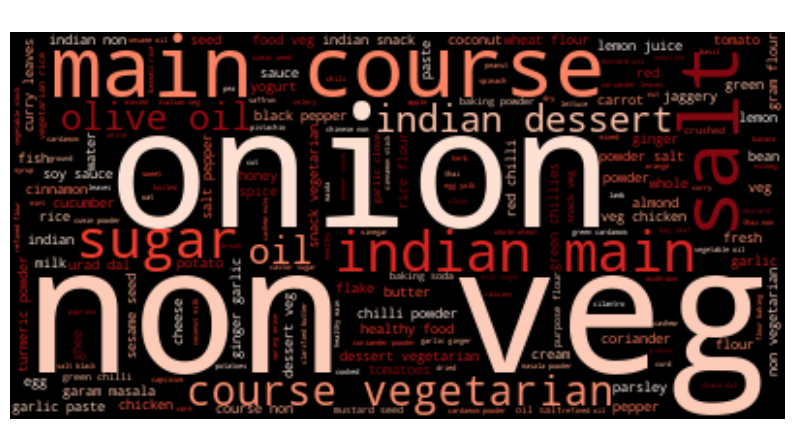

In [18]:
titles = all_dishes['describe'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Descriptions', color='white')
plt.show()

## TF-IDF 

Term Frequency-Inverse Document Frequency (TF-IDF) for each ingredient. Give higher weights to ingredients that are important for a specific dish but less frequent in others, which might be more useful for recommendation purposes.

In [19]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(all_dishes['describe'])

In [20]:
#cosine similarity 

cosine_sim = cosine_similarity(tfid_matrix, tfid_matrix)
cosine_sim

array([[1.        , 0.02870006, 0.        , ..., 0.14395335, 0.02296613,
        0.13364592],
       [0.02870006, 1.        , 0.13979103, ..., 0.07884286, 0.02396984,
        0.05597663],
       [0.        , 0.13979103, 1.        , ..., 0.0087594 , 0.04101134,
        0.00572097],
       ...,
       [0.14395335, 0.07884286, 0.0087594 , ..., 1.        , 0.06181164,
        0.00509089],
       [0.02296613, 0.02396984, 0.04101134, ..., 0.06181164, 1.        ,
        0.00801075],
       [0.13364592, 0.05597663, 0.00572097, ..., 0.00509089, 0.00801075,
        1.        ]])

In [21]:
print("Shape of our dishes: ", all_dishes.shape)
print("Shape of cosine similarity matrix: ", cosine_sim.shape)

#(683, 683) meaning we have computed a similarity score for each pair of dishes in our dataset.

Shape of our dishes:  (723, 2)
Shape of cosine similarity matrix:  (723, 723)


In [22]:
def rank(title, cosine_sim = cosine_sim, dish_matrix = all_dishes):
    title = title.lower()
    idx = dish_matrix.index[dish_matrix['name'] == title].tolist()
    match_food = np.array(cosine_sim[idx[0]])
    indices = np.argsort(match_food)[-6:][::-1][1:]                #get the index of the top 5 similar dishes in decendening order
    
    return indices
    
def print_similar_dishes(title, indices = None, dish_matrix = all_dishes):
    indices = rank(title, cosine_sim = cosine_sim, dish_matrix = all_dishes)
    print("Top 5 similar dishes to", title, "are:")
    for i in range(0,len(indices)):
        print(i+1, ". ", dish_matrix['name'].iloc[indices[i]])
        
def rank_for_gradio(title):
    indices = rank(title)
    similar_dishes = [all_dishes.iloc[i]['name'] for i in indices]
    formatted_dishes = "\n".join([f"{i+1}. {dish}" for i, dish in enumerate(similar_dishes)])
    return formatted_dishes
   

In [23]:
print_similar_dishes('Shawarma', all_dishes)

Top 5 similar dishes to Shawarma are:
1 .  hummus
2 .  mandi
3 .  vindaloo
4 .  mujaddara
5 .  baba ganoush


In [24]:
print_similar_dishes('crispy herb chicken', all_dishes)

Top 5 similar dishes to crispy herb chicken are:
1 .  chicken parmigiana tomato sauce
2 .  mustard parmesan whole roasted cauliflower
3 .  beetroot green apple soup
4 .  kerala fish curry
5 .  kale channe ki biryani


In [25]:
print_similar_dishes('Pho Chay Soup', all_dishes)

Top 5 similar dishes to Pho Chay Soup are:
1 .  pho ga chicken
2 .  bean curd rolls
3 .  pho tai rare beef
4 .  mushroom rice
5 .  cheera doi


In [26]:
print_similar_dishes('Kale Caesar Salad', all_dishes)

Top 5 similar dishes to Kale Caesar Salad are:
1 .  parmesan toasts
2 .  kale smoothie
3 .  zucchini noodles
4 .  mushroom risotto
5 .  quinoa salad


In [27]:
print_similar_dishes('Adhirasam', all_dishes)

Top 5 similar dishes to Adhirasam are:
1 .  ariselu
2 .  modak
3 .  kajjikaya
4 .  pongal
5 .  unni appam


In [28]:
#export the data as csv
all_dishes.to_csv('all_dishes.csv', index=False)

## Front-end

In [29]:
# Setup Gradio interface
#css_code = ".gradio-container {background: url(https://cdn.pixabay.com/photo/2024/06/22/08/07/ai-generated-8845695_1280.jpg)}"
# css_code = ".gradio-container {background: url(https://img.freepik.com/free-photo/elevated-view-ingredients-dryfruits-vegetables-black-background_23-2148026898.jpg?w=1480&t=st=1727902059~exp=1727902659~hmac=4f7f4e8f697f78d214ab8f9ee921baa16a01f17683c9b1f44779effcdb546ef9)}"

# iface = gr.Interface(
#     fn=rank_for_gradio,
#     inputs=gr.Dropdown(list(all_dishes["name"]), label="Choose a Dish"),
#     outputs=gr.Text(label="Top 5 Similar Dishes that you might like"),
#     title="Personalized Dish Recommender",
#     description="Select a dish to find the top 5 similar dishes based on their descriptions.",
#     css=css_code,
# )
css_code = """
.gradio-container {
    background: url(https://cdn.pixabay.com/photo/2024/06/22/08/07/ai-generated-8845695_1280.jpg);
}

/* Styling for the title and description box */
.title-desc-box {
    background-color: #f8f9fa;  /* Light grey background */
    border: 1px solid #dee2e6;  /* Grey border */
    border-radius: 10px;        /* Rounded corners */
    padding: 20px;              /* Padding around text */
    margin: 20px;               /* Margin around the box */
}

/* Custom title styling */
h1, h2 {
    color: #333;                /* Dark grey text color */
    text-align: center;         /* Center-align text */
}

/* Custom description styling */
p {
    color: #555;                /* Medium grey text color */
    font-size: 16px;            /* Larger font size */
}
"""

# Interface initialization with modified css
iface = gr.Interface(
    fn=rank_for_gradio,
    inputs=gr.Dropdown(list(all_dishes["name"]), label="Choose a Dish"),
    outputs=gr.Text(label="Top 5 Similar Dishes that you might like"),
    title="<div class='title-desc-box'><h1>Personalized Dish Recommender</h1><p>Select a dish to find the top 5 similar dishes based on their descriptions.</p></div>",
    description="",
    css=css_code,
)


In [30]:
# Launch the interface
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://d8ac029434cdc6c0e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Gradio Deployment

In [31]:
!pip install huggingface_hub